## Метод К-средних

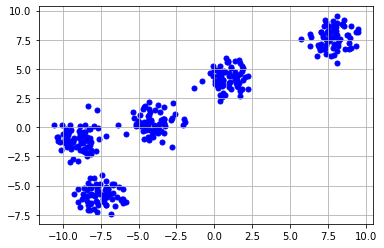

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np


X, y = make_blobs(n_samples=350, 
                  n_features=2, 
                  centers=5,
                  cluster_std=0.8, 
                  shuffle=True, 
                  random_state=3)
plt.scatter(X[:,0], X[:,1], c='b', marker='o', s=25)
plt.grid()

Число итераций random_init:  4
Inertia: 460.55


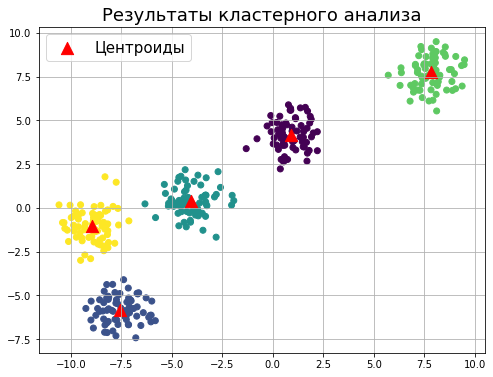

In [2]:
from sklearn.cluster import KMeans


km = KMeans(n_clusters=5,
            init='random',
            n_init=10,
            max_iter=300,
            random_state=0)
y_km = km.fit_predict(X)
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=km.labels_)
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            marker='^', 
            c='r', 
            s=150, 
            label='Центроиды')
plt.grid()
plt.legend(fontsize=15)
plt.title('Результаты кластерного анализа', fontdict={'fontsize': 18})
print('Число итераций random_init: ', km.n_iter_)
print('Inertia: %.2f' % km.inertia_)

In [3]:
km = KMeans(n_clusters=5,
            init='k-means++',
            n_init=10,
            max_iter=300,
            random_state=0)
km.fit_predict(X)
print('Число итераций k-means++: ', km.n_iter_)
print('Inertia: %.2f' % km.inertia_)

Число итераций k-means++:  2
Inertia: 460.55


Метод локтя для подбора числа кластеров k

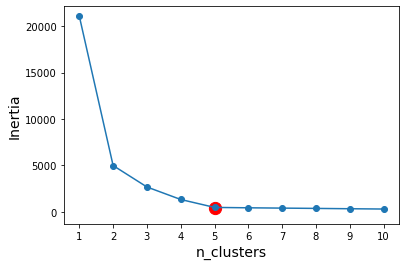

In [4]:
inert = []
for i in range(1, 11) :
    km = KMeans(n_clusters=i, 
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(X)
    inert.append(km.inertia_)
plt.plot(range(1, 11), inert, marker='o')
plt.scatter(5, inert[5], marker='o', c='r', s=150, alpha=1)
plt.xticks(range(1, 11))
plt.xlabel('n_clusters', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.show()

Силуэтный анализ

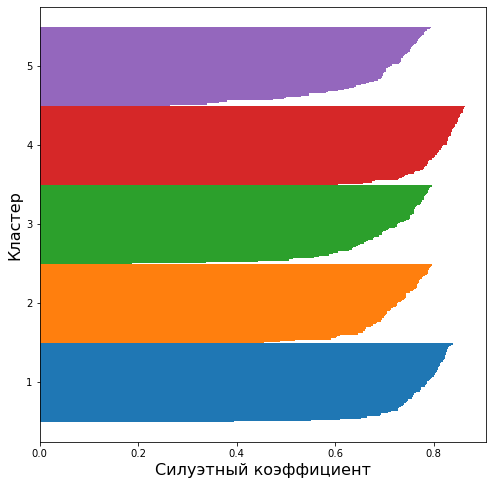

In [5]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples


cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
plt.figure(figsize=(8,8))
for i, с in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == с]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    plt.barh(range(y_ax_lower, y_ax_upper),
             c_silhouette_vals,
             height=1.0)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Кластер', fontsize=16)
plt.xlabel('Силуэтный коэффициент', fontsize=16)
plt.show()

## Иерархическая кластеризация (агломеративная, с методом полной связи)

In [6]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd


np.random.seed(123)
X = np.random.random_sample([10, 4])*10
labels = ['obj_' + str(i) for i in range(X.shape[0])]
features = ['x_' + str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=features, index=labels)
df

,x_0,x_1,x_2,x_3
obj_0,6.964692,2.861393,2.268515,5.513148
obj_1,7.194690,4.231065,9.807642,6.848297
obj_2,4.809319,3.921175,3.431780,7.290497
obj_3,4.385722,0.596779,3.980443,7.379954
obj_4,1.824917,1.754518,5.315514,5.318276
obj_5,6.344010,8.494318,7.244553,6.110235
obj_6,7.224434,3.229589,3.617887,2.282632
obj_7,2.937140,6.309761,0.921049,4.337012
obj_8,4.308628,4.936851,4.258303,3.122612
obj_9,4.263513,8.933892,9.441600,5.018367


In [7]:
ac = AgglomerativeClustering(distance_threshold=0, 
                             n_clusters=None, 
                             affinity='euclidean', 
                             linkage='complete')
model_ac = ac.fit(X)
# формируем матрицу связей linkage_matrix 
counts = np.zeros(model_ac.children_.shape[0])
n_samples = len(model_ac.labels_)
for i, merge in enumerate(model_ac.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count
linkage_matrix = np.column_stack([
    model_ac.children_, model_ac.distances_, counts]).astype(float)
linkage_matrix

array([[ 0.        ,  2.        ,  3.20638852,  2.        ],
       [ 5.        ,  9.        ,  3.24667253,  2.        ],
       [ 6.        ,  8.        ,  3.54010849,  2.        ],
       [ 3.        ,  4.        ,  3.73242731,  2.        ],
       [ 7.        , 10.        ,  5.5956563 ,  3.        ],
       [ 1.        , 11.        ,  5.84730803,  3.        ],
       [12.        , 14.        ,  6.27389432,  5.        ],
       [13.        , 16.        ,  7.30451509,  7.        ],
       [15.        , 17.        , 10.37910346, 10.        ]])

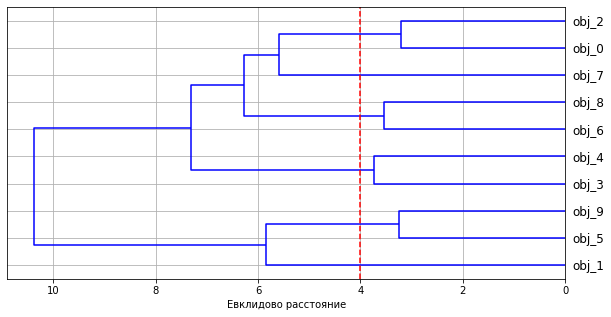

In [8]:
from scipy.cluster.hierarchy import dendrogram, fcluster


plt.figure(figsize=(10,5))
dendrogram(linkage_matrix, labels=labels, orientation='left', color_threshold=0)
plt.axvline(4, color="red", linestyle="--")
plt.grid()
plt.xlabel('Евклидово расстояние')
plt.show()

In [9]:
label = fcluster(linkage_matrix, 4, criterion='distance')
print(np.unique(label))
df.loc[:,'label'] = label
df

[1 2 3 4 5 6]


,x_0,x_1,x_2,x_3,label
obj_0,6.964692,2.861393,2.268515,5.513148,5
obj_1,7.194690,4.231065,9.807642,6.848297,2
obj_2,4.809319,3.921175,3.431780,7.290497,5
obj_3,4.385722,0.596779,3.980443,7.379954,3
obj_4,1.824917,1.754518,5.315514,5.318276,3
obj_5,6.344010,8.494318,7.244553,6.110235,1
obj_6,7.224434,3.229589,3.617887,2.282632,4
obj_7,2.937140,6.309761,0.921049,4.337012,6
obj_8,4.308628,4.936851,4.258303,3.122612,4
obj_9,4.263513,8.933892,9.441600,5.018367,1


In [10]:
for i, group in df.groupby('label'):
    print('-' * 55)
    print('cluster {}'.format(i))
    print(group)

-------------------------------------------------------
cluster 1
            x_0       x_1       x_2       x_3  label
obj_5  6.344010  8.494318  7.244553  6.110235      1
obj_9  4.263513  8.933892  9.441600  5.018367      1
-------------------------------------------------------
cluster 2
           x_0       x_1       x_2       x_3  label
obj_1  7.19469  4.231065  9.807642  6.848297      2
-------------------------------------------------------
cluster 3
            x_0       x_1       x_2       x_3  label
obj_3  4.385722  0.596779  3.980443  7.379954      3
obj_4  1.824917  1.754518  5.315514  5.318276      3
-------------------------------------------------------
cluster 4
            x_0       x_1       x_2       x_3  label
obj_6  7.224434  3.229589  3.617887  2.282632      4
obj_8  4.308628  4.936851  4.258303  3.122612      4
-------------------------------------------------------
cluster 5
            x_0       x_1       x_2       x_3  label
obj_0  6.964692  2.861393  2.268515 

## DBSCAN (плотностная кластеризация)

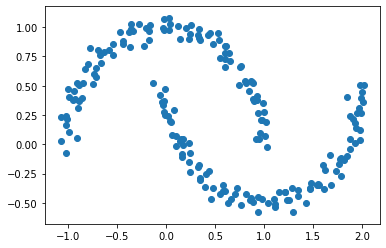

In [12]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=200,noise=0.05, random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.show()

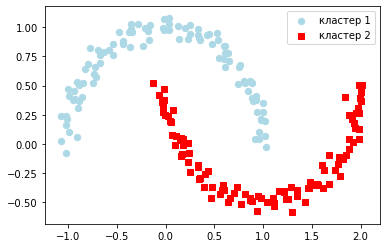

In [13]:
from sklearn.cluster import DBSCAN


db = DBSCAN(eps=0.2,
            min_samples=5,
            metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0,0], X[y_db==0,1],
            c='lightblue', marker='o',
            s=40, label='кластер 1')
plt.scatter(X[y_db==1,0], X[y_db==1,1],
            c='red', marker='s',
            s=40, label='кластер 2')
plt.legend()
plt.show()